# Getting Started with Temporian

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/main/docs/src/tutorials/toy_example.ipynb)

## Setup

In [ ]:
# Skip this cell if you are running the notebook locally and have already installed temporian.
%pip install temporian

In [1]:
import temporian as tp

import pandas as pd
import numpy as np

## Example Data

This minimal data consists of just one `signal` with a `timestamp` for each sample.

The signal is a periodic sinusoidal `season` with a slight positive slope in the long run, which we call `trend`. Plus the ubiquitous `noise`.

In [2]:
# Generate a synthetic dataset
timestamps = np.arange(0, 100, 0.1)
n = len(timestamps)
noise = 0.1 * np.random.randn(n)
trend = 0.01 * timestamps
season = 0.4 * np.sin(0.5 * timestamps)

raw_data = pd.DataFrame(
    {
        "timestamp": timestamps,
        "noise": noise,
        "trend": trend,
        "season": season,
        "signal": noise + trend + season,
    }
)

raw_data

,timestamp,noise,trend,season,signal
0,0.0,0.029369,0.000,0.000000,0.029369
1,0.1,-0.025819,0.001,0.019992,-0.004827
2,0.2,0.011802,0.002,0.039933,0.053735
3,0.3,0.028317,0.003,0.059775,0.091092
4,0.4,0.018985,0.004,0.079468,0.102453
...,...,...,...,...,...
995,99.5,-0.071741,0.995,-0.197182,0.726077
996,99.6,-0.049279,0.996,-0.179542,0.767180
997,99.7,0.019068,0.997,-0.161453,0.854616
998,99.8,0.171779,0.998,-0.142960,1.026820


## Part 1: Loading Data

Any kind of signal is represented in Temporian as a **collection of events**, using the `EventSet` object.

In this case there's no `indexes` because we only have one sequence.

Indices could be useful if we had multiple signals in parallel.
For example, imagine that we needed to work with signals from multiple sensor devices, or represent the sales from many stores or products: we could separate them by setting the correct features as indexes for each one.

In [3]:
# Convert the dataset into a Temporian dataset

source_data = tp.from_pandas(raw_data)

source_data

indexes: []
features: [('noise', float64), ('trend', float64), ('season', float64), ('signal', float64)]
events:
     (1000 events):
        timestamps: [ 0.   0.1  0.2 ... 99.7 99.8 99.9]
        'noise': [ 0.0294 -0.0258  0.0118 ...  0.0191  0.1718 -0.011 ]
        'trend': [0.    0.001 0.002 ... 0.997 0.998 0.999]
        'season': [ 0.      0.02    0.0399 ... -0.1615 -0.143  -0.1241]
        'signal': [ 0.0294 -0.0048  0.0537 ...  0.8546  1.0268  0.8639]
memory usage: 40.8 kB

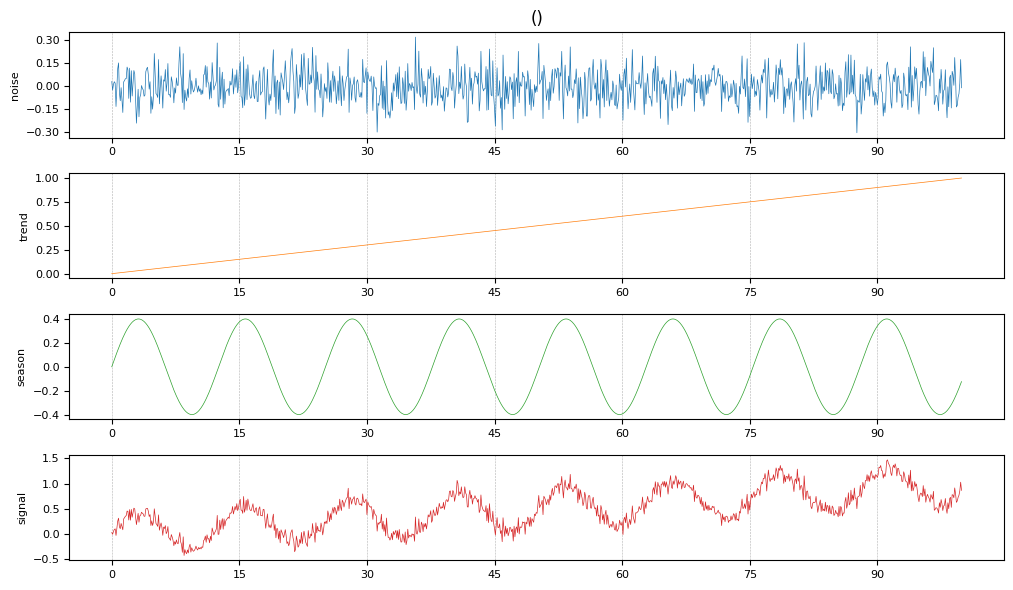

In [4]:
# Plot the dataset
_ = source_data.plot()

**Note:** If you're wondering why the plot has an empty `()` in the title, it's because we have no `indexes`, as mentioned above.

## Part 2: Operations and Graph

Now, we'll actually transform our temporal data using some operations:
- Using a moving average with a large window, the long-term `trend` slope is captured (sinusoid and noise will average 0).
- The trend can be then subtracted from the original signal to get only the sinusoidal component `detrend`.
- The above process is repeated to refine the results in `trend2` and `detrend2`, and to show how the operations can be chained.
- The `slope` of one of the signals is calculated, by subtracting a delayed version of itself. Note that the time axis for this plot is shifted.

Read below to understand the purpose of `node()`, `evaluate()`, `glue()` and `rename()`.

In [5]:
# Input node of the graph
source = source_data.node()

# Define the graph of operations
signal = source["signal"]
trend = tp.simple_moving_average(signal, tp.duration.minutes(1))
detrend = signal - trend
trend2 = tp.simple_moving_average(detrend, 25)  # duration in seconds
detrend2 = detrend - trend2
slope = trend2 - tp.resample(tp.lag(trend2, 20), trend2)

# Pack results to show in the plots below
result = tp.glue(
    signal,
    tp.rename(trend, "trend"),
    tp.rename(detrend, "detrend"),
    tp.rename(trend2, "trend2"),
    tp.rename(detrend2, "detrend2"),
    tp.rename(slope, "slope"),
)

result_data = tp.evaluate(result, {source: source_data})

result_data

indexes: []
features: [('signal', float64), ('trend', float64), ('detrend', float64), ('trend2', float64), ('detrend2', float64), ('slope', float64)]
events:
     (1000 events):
        timestamps: [ 0.   0.1  0.2 ... 99.7 99.8 99.9]
        'signal': [ 0.0294 -0.0048  0.0537 ...  0.8546  1.0268  0.8639]
        'trend': [0.0294 0.0123 0.0261 ... 0.6872 0.6875 0.6877]
        'detrend': [ 0.     -0.0171  0.0276 ...  0.1674  0.3393  0.1762]
        'trend2': [ 0.     -0.0085  0.0035 ...  0.301   0.3025  0.3024]
        'detrend2': [ 0.     -0.0085  0.0241 ... -0.1336  0.0368 -0.1261]
        'slope': [   nan    nan    nan ... 0.0128 0.0131 0.0127]
memory usage: 57.1 kB

### Visualizing the results
Ok, the text representation is not the best to understand the `result_data`.

Let's plot the results instead.

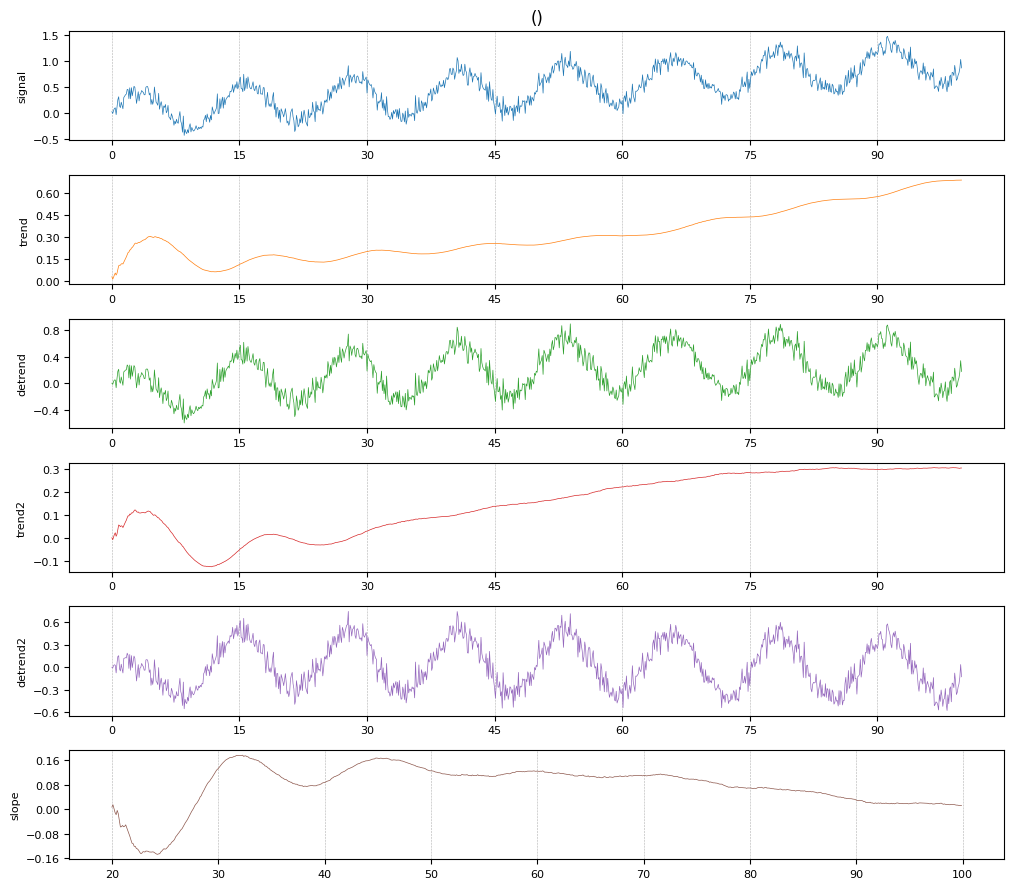

In [6]:
result_data.plot()

### Why `node()` and `evaluate()`?
The sequence of operations that Temporian needs to apply to the input data is represented by a graph. The nodes are placeholders for the data and they are connected by operators, which are the edges of the graph. The output of any operator is a new node, which can be used downstream in new operations.

So this code can be divided in two stages:
1. **Define the graph**, by chaining operations from the source node (aka input node).
2. **Evaluate the graph** at some given node(s), providing the data for the source node and executing the whole sequence of operations up to that output node (or multiple output nodes).

You might want to check the **[3 minutes to Temporian](https://temporian.readthedocs.io/en/latest/3_minutes/)** guide to understand better the difference between an `EventSet` and a `Node`.

The input node of the graph could instead be created using `tp.input_node()` and specifying the feature names and types manually. However, since we already have the `source_data` loaded with the proper features, we use its `node()` method to create a proper source `Node` from it, in this case.

Anyway, it's important to note that the actual data is not being processed during the graph definition.
The pipeline starts pumping only when `evaluate()` is called with the actual data for the input node. And this process could be repeated with different inputs without redefining the graph. For example, let's create new input data and re-evaluate the graph at the same `result` node:

Build schedule
Run 14 operators
    1 / 14: SELECT [0.00012 s]
    2 / 14: SIMPLE_MOVING_AVERAGE [0.00014 s]
    3 / 14: RENAME [0.00006 s]
    4 / 14: SUBTRACTION [0.00009 s]
    5 / 14: RENAME [0.00035 s]
    6 / 14: SIMPLE_MOVING_AVERAGE [0.00009 s]
    7 / 14: SUBTRACTION [0.00008 s]
    8 / 14: RENAME [0.00005 s]
    9 / 14: LAG [0.00008 s]
    10 / 14: RESAMPLE [0.00019 s]
    11 / 14: RENAME [0.00005 s]
    12 / 14: SUBTRACTION [0.00008 s]
    13 / 14: RENAME [0.00005 s]
    14 / 14: GLUE [0.00009 s]
Execution in 0.00656 s


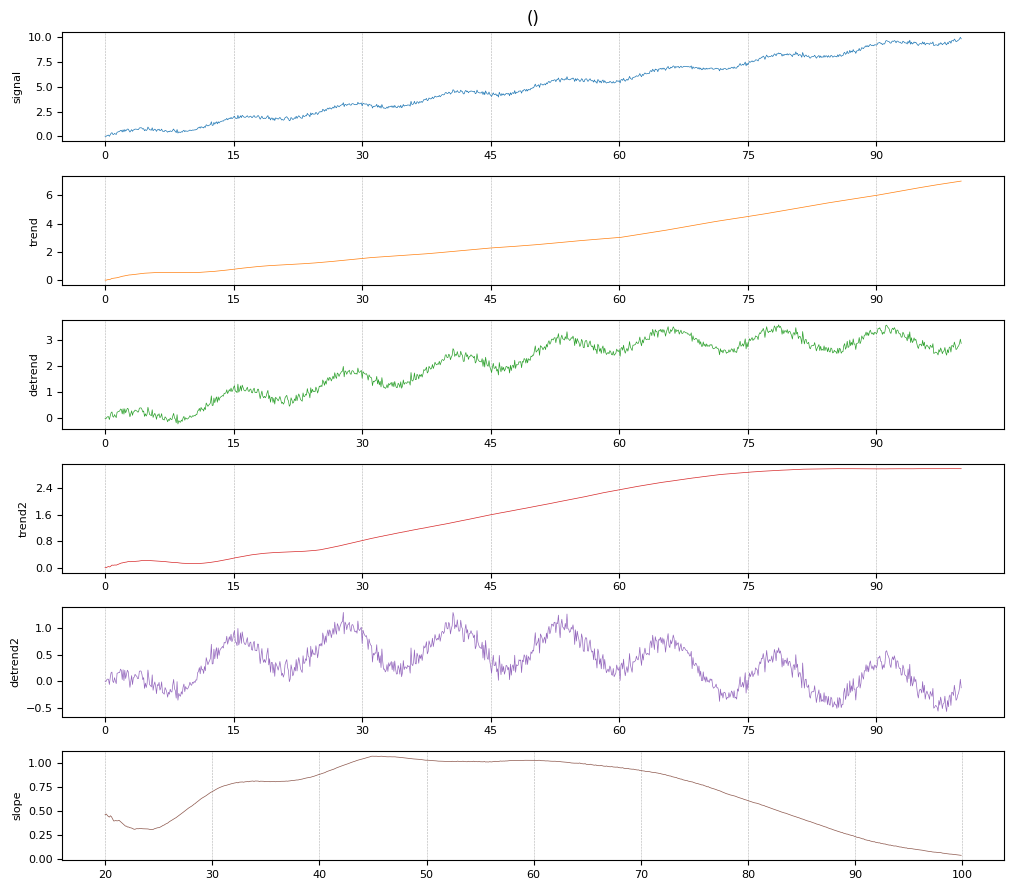

In [7]:
# Slightly modify our previous input DataFrame and recreate EventSet
new_data = raw_data.copy()
new_data["trend"] *= 9
new_data["signal"] += new_data["trend"]
new_source_data = tp.from_pandas(new_data)

# Re-evaluate the graph (previously defined)
new_result_data = result.evaluate({source: new_source_data})
new_result_data.plot()

### Why `glue()` and `rename()`?

Any node of the graph (e.g: `signal`, `result` or `trend`) always has at least one feature. You can select and combine features to create new nodes using two operations:
1. **Select:** using `source["signal"]` or `source[["feature_1", "feature_2"]]` will return a new `Node` object with only one or two features respectively.
1. **Glue:** using `tp.glue(node_1, node_2)` will return a new `Node` combining all features from those input nodes.

#### Feature naming
The feature names after applying an operator to a `Node` might change or not, mostly according to the following criteria:
- If the operator uses only one input node (e.g: `simple_moving_average`), the output feature names are the same as the input.
- If the operator involves two input nodes (e.g: arithmetics like `+-*/`), which node's feature names should we use? We join those names. For example, adding `node[["f1", "f2"]] + node[["f3", "f4"]]` results in a node with two features: `["add_f1_f3", "add_f2_f4"]` (we're adding features in the same position).

By using the `rename()` operator, we avoid long feature names and get predictable results.

The alternative `prefix()` operator might come handy in some cases. For example, if you wanted to glue together the input and output from a `simple_moving_average` operation, the feature names will be repeated (because input/output feature names are the same). You can resolve this by adding a prefix to the output name:

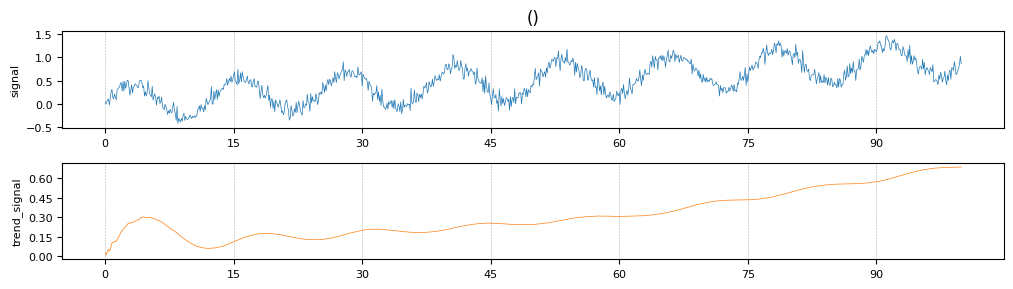

In [8]:
# Using prefix() instead of rename()
result_prefix = tp.glue(
    signal,
    # `signal` and `trend` have the same feature name by default
    tp.prefix("trend_", trend)
)
tp.evaluate(result_prefix, {source: source_data}).plot()

### Exporting outputs from Temporian
Of course you may need to use this data in different ways for downstream tasks, like training a model using whatever library you need. 

If you can't use the data directly from Temporian, you can always go back to a pandas DataFrame:

In [9]:
tp.to_pandas(result_data)

,signal,trend,detrend,trend2,detrend2,slope,timestamp
0,0.029369,0.029369,0.000000,0.000000,0.000000,NaN,0.0
1,-0.004827,0.012271,-0.017098,-0.008549,-0.008549,NaN,0.1
2,0.053735,0.026092,0.027643,0.003515,0.024128,NaN,0.2
3,0.091092,0.042342,0.048750,0.014824,0.033926,NaN,0.3
4,0.102453,0.054364,0.048089,0.021477,0.026612,NaN,0.4
...,...,...,...,...,...,...,...
995,0.726077,0.687039,0.039038,0.302154,-0.263117,0.013928,99.5
996,0.767180,0.687185,0.079994,0.301720,-0.221726,0.013449,99.6
997,0.854616,0.687204,0.167412,0.300985,-0.133573,0.012797,99.7
998,1.026820,0.687493,0.339326,0.302502,0.036824,0.013055,99.8


## Part 3: Using `indexes`
This is the final important concept to get from this introduction.

Indexes are useful to handle multiple signals in parallel (as mentioned at the top of this notebook).
For example, working with signals from multiple sensor devices or representing sales from many stores or products. The feature names may be exactly the same for all the data, but we need to separate them by setting the correct `indexes` for each one.

### New example data: multiple devices
Let's create two signals with overlapping timestamps, with a different `signal_id`:

In [10]:
# Reuse DataFrames to create one with two signals with overlapping timestamps
data_i1 = raw_data.copy()[:900]
data_i2 = new_data.copy()[300:]
data_i1["device_id"] = "Device 1"
data_i2["device_id"] = "Device 2"
data_indices = pd.concat([data_i1, data_i2])
data_indices

,timestamp,noise,trend,season,signal,device_id
0,0.0,0.029369,0.000,0.000000,0.029369,Device 1
1,0.1,-0.025819,0.001,0.019992,-0.004827,Device 1
2,0.2,0.011802,0.002,0.039933,0.053735,Device 1
3,0.3,0.028317,0.003,0.059775,0.091092,Device 1
4,0.4,0.018985,0.004,0.079468,0.102453,Device 1
...,...,...,...,...,...,...
995,99.5,-0.071741,8.955,-0.197182,9.681077,Device 2
996,99.6,-0.049279,8.964,-0.179542,9.731180,Device 2
997,99.7,0.019068,8.973,-0.161453,9.827616,Device 2
998,99.8,0.171779,8.982,-0.142960,10.008820,Device 2


### `EventSet` with `indexes`
Let's convert the dataframe to a Temporian `EventSet`, but this time specifying `indexes`, and see if the string representation makes sense now:

In [11]:
source_data_i = tp.from_pandas(data_indices, indexes=["device_id"])
source_data_i

indexes: [('device_id', str_)]
features: [('noise', float64), ('trend', float64), ('season', float64), ('signal', float64)]
events:
    device_id=Device 1 (900 events):
        timestamps: [ 0.   0.1  0.2 ... 89.7 89.8 89.9]
        'noise': [ 0.0294 -0.0258  0.0118 ... -0.1228 -0.0404 -0.0685]
        'trend': [0.    0.001 0.002 ... 0.897 0.898 0.899]
        'season': [0.     0.02   0.0399 ... 0.3051 0.3177 0.3294]
        'signal': [ 0.0294 -0.0048  0.0537 ...  1.0793  1.1753  1.1599]
    device_id=Device 2 (700 events):
        timestamps: [30.  30.1 30.2 ... 99.7 99.8 99.9]
        'noise': [-0.1759  0.0921  0.0529 ...  0.0191  0.1718 -0.011 ]
        'trend': [2.7   2.709 2.718 ... 8.973 8.982 8.991]
        'season': [ 0.2601  0.2446  0.2285 ... -0.1615 -0.143  -0.1241]
        'signal': [ 3.0842  3.3467  3.3014 ...  9.8276 10.0088  9.8549]
memory usage: 65.5 kB

### Results with `indexes`

We can't reuse the graph from previous sections, since the `indexes` are part of the definition of a `Node`, just like the features are.

Any operation that we apply now must be aware of it and will be performed over each index group separately. In this case, we're using a simpler graph since we only need one operation to illustrate the concept, but feel free to add complexity and check the results!

Finally, make sure to see how the plots are adjusted to show the signals for each index group. In particular, see how the timestamps are different and partly overlapping, and that's completely fine for separate indices (it wouldn't be possible to accomodate that using different features, for example).

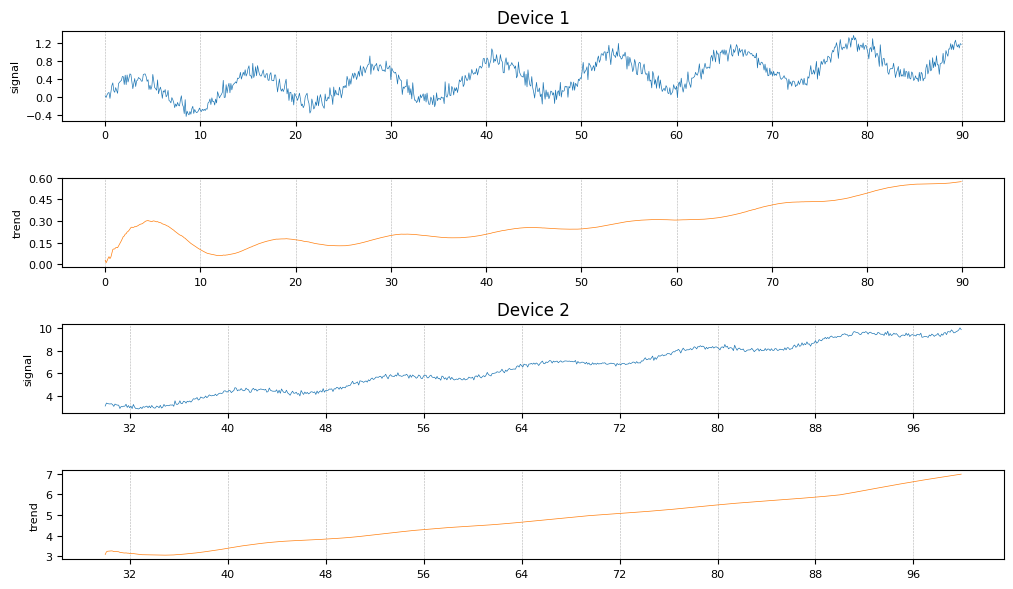

In [12]:
# Create the input node
source_i = source_data_i.node()

# Graph definition
signal_i = source_i["signal"]
trend_i = tp.simple_moving_average(signal_i, tp.duration.minutes(1))
result_i = tp.glue(signal_i, tp.rename(trend_i, "trend"))

# Evaluate and plot
result_data_i = tp.evaluate(result_i, {source_i: source_data_i})
result_data_i.plot()

### Multi-indices

Finally, let's point out that indices may include multiple columns of the input data.

For example, in the case of sales in a store, we could use the store/product pair to index each sequence.

This is easy to do since the `index_names` argument is actually a list of columns, and it's represented in Temporian by using a tuple `(store, product)` as the index value (i.e: it's basically the same as using a concatenation like `f"{store}_{product}` as the index).

## Summary

Congratulations! You now have the basic concepts needed to create a data preprocessing pipeline with Temporian:
- Defining a **graph** using **nodes** and **operators**.
- Combine **features** using **select** and **glue**.
- Running the **evaluate** step and using input and output data.
- Coverting data back and forth between Temporian's **EventSet** and pandas **DataFrames**.
- Visualizing input/output data using **EventSet.plot()**.
- Using an **index** to separate signals in the graph operations and plots.

### What's Missing and Next Steps

There are important things we could not include in this introduction:

- In this example we used a signal with uniform sampling (equal distance between event timestamps), but Temporian can handle non-uniform data just as easily. Read more about the data representation on the **[User Guide's introduction](https://temporian.readthedocs.io/en/latest/user_guide/)**.
- Temporian is **strict on the feature types** when applying operations, to avoid potentially silent errors or memory issues. For example, you cannot perform binary operations (e.g: arithmetics or comparisons) between features with different types. Check the [User Guide's **casting** section](https://temporian.readthedocs.io/en/latest/user_guide/#casting) section to learn how to tackle those cases.
- In this case, we only used seconds as the timestamps of the signal, but you might as well use calendar dates. Learn more about it on the [**Time Units** section of the User Guide](https://temporian.readthedocs.io/en/latest/user_guide/#time-units). After reading that section, check that there are many [**calendar operators**](https://temporian.readthedocs.io/en/latest/reference/temporian/core/operators/all_operators/#temporian.core.operators.all_operators.calendar_day_of_month) available when working with date timestamps.
- If you need to manipulate the timestamp of events, check the [User Guide's **sampling** section](https://temporian.readthedocs.io/en/latest/user_guide/#sampling) to learn more about this.
- We only used moving average here, but there are a bunch of other [**moving window**](https://temporian.readthedocs.io/en/latest/reference/temporian/core/operators/all_operators/#temporian.core.operators.all_operators.moving_count) operators, frequently useful for time sequences manipulation.

Always keep in mind these resources:
- Read the [**3 minutes to Temporian**](https://temporian.readthedocs.io/en/latest/3_minutes/) guide to review the `EventSet`, `Node` and graph related concepts.
- Try the more advanced [**tutorials**](https://temporian.readthedocs.io/en/latest/tutorials/) to continue learning by example about all these topics and more!
- We could only cover a small fraction of **[all available operators](https://temporian.readthedocs.io/en/latest/reference/temporian/core/operators/all_operators/)**.
- We put a lot of ❤️ in the **[User Guide](https://temporian.readthedocs.io/en/latest/user_guide/)**, so make sure to check it out 🙂.